In [1]:
import numpy as np
import scipy.fft as sfft
import matplotlib.pyplot as plt
%matplotlib inline

from devito import Grid, Function, TimeFunction, SparseTimeFunction, solve, Eq, Operator, Buffer
from examples.seismic import Model, plot_velocity, TimeAxis, RickerSource, Receiver, AcquisitionGeometry

Text(0.5,1,'|fft($u$)| at $t=0$')

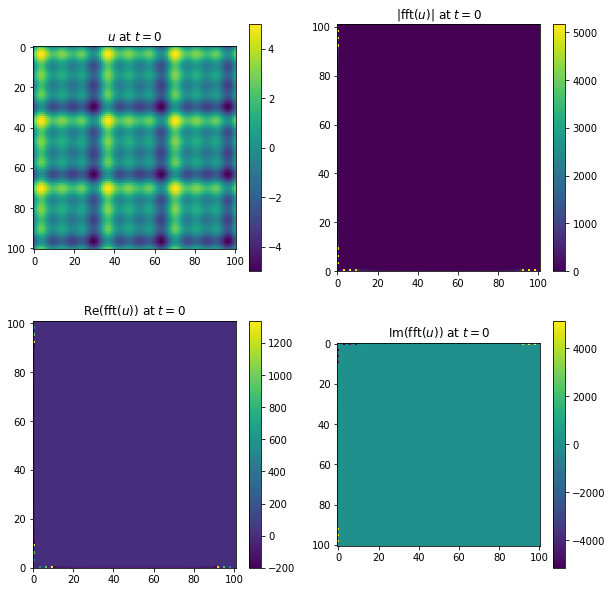

In [280]:
K = 3
def set_ic(u):
    for i in range(u.shape[0]):
        y = i / (u.shape[0]-1)
        for j in range(u.shape[1]):
            x = j / (u.shape[1]-1)
            for k in range(1, K+1):
                u[i, j] += np.sin(2 * K * np.pi * k * y) + np.sin(2 * K * np.pi * k * x)
#             for ii in range(1, N+1):
#                 for jj in range(1, N+1):
#                     u[i, j] += np.sin(ii*x + jj*y)
            
    return u

size = (101, 101)
u = np.zeros(size)
u = set_ic(u)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
plot_00 = axs[0, 0].imshow(u)
axs[0, 0].set_title(r"$u$ at $t=0$")
cbar00 = fig.colorbar(plot_00, ax=axs[0, 0])

u_fft = sfft.fft2(u)
lvs = np.linspace(np.min(np.imag(u_fft)), np.max(np.imag(u_fft)), 100)
plot_01 = axs[1, 1].imshow(np.imag(u_fft))
cbar01 = fig.colorbar(plot_01, ax=axs[1, 1])
axs[1, 1].set_title(r"Im(fft($u$)) at $t=0$")

plot_10 = axs[1, 0].pcolor(np.real(u_fft).T)
cbar10 = fig.colorbar(plot_10, ax=axs[1, 0])
axs[1, 0].set_title(r"Re(fft($u$)) at $t=0$")

u_recom = sfft.ifft2(u_fft)
plot_11 = axs[0, 1].pcolor(np.abs(u_fft).T)
cbar11 = fig.colorbar(plot_11, ax=axs[0, 1])
axs[0, 1].set_title(r"|fft($u$)| at $t=0$")

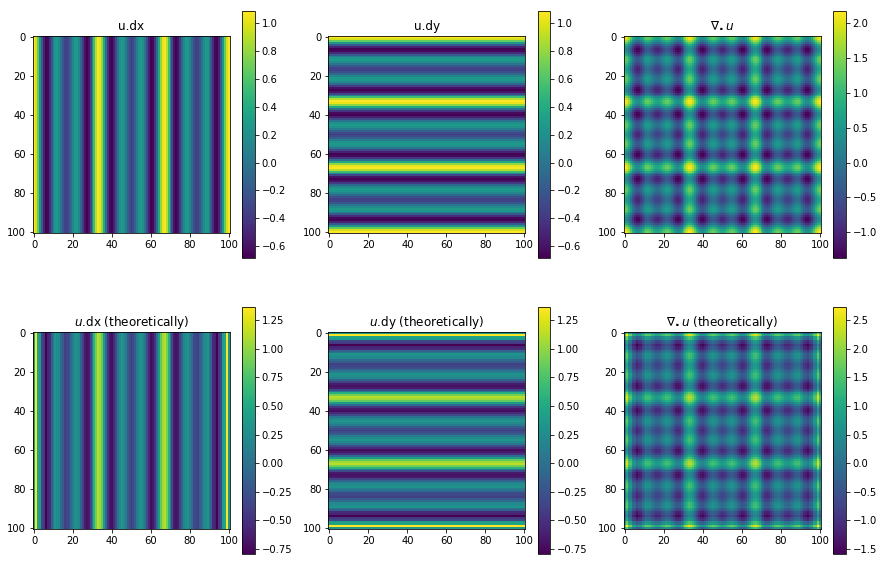

In [289]:
u_dx = np.zeros(u.shape)
u_dy = np.zeros(u.shape)
dx = dy = 1
for i in range(u.shape[0]):
    for j in range(u.shape[1]):
        if i == 0:                # Top row
            u_dy[i, j] = (u[i+1, j] - u[i, j]) / dy
        elif i == u.shape[0] - 1: # Last row
            u_dy[i, j] = (u[i, j] - u[i-1, j]) / dy
        else:
            u_dy[i, j] = (u[i+1, j] - u[i-1, j]) / (2*dy)
        
        if j == 0:                # First column
            u_dx[i, j] = (u[i, j+1] - u[i, j]) / dx
        elif j == u.shape[1] - 1: # Last column
            u_dx[i, j] = (u[i, j] - u[i, j-1]) / dx
        else:
            u_dx[i, j] = (u[i, j+1] - u[i, j-1]) / (2*dx)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
plot_00 = axs[0, 0].imshow(u_dx)
axs[0, 0].set_title("u.dx")
_ = fig.colorbar(plot_00, ax=axs[0, 0])

plot_01 = axs[0, 1].imshow(u_dy)
axs[0, 1].set_title("u.dy")
_ = fig.colorbar(plot_01, ax=axs[0, 1])

plot_02 = axs[0, 2].imshow((u_dx + u_dy))
axs[0, 2].set_title(r"$\nabla \mathbf{.} u$")
_ = fig.colorbar(plot_02, ax=axs[0, 2])

f_x = sfft.fftfreq(u.shape[0])
f_y = sfft.fftfreq(u.shape[1])
# print(f_x, f_y)
scaled_ufftx, scaled_uffty = np.zeros(u_fft.shape, dtype=complex), np.zeros(u_fft.shape, dtype=complex)
normalized_div = np.zeros(u_fft.shape, dtype=complex)
normalized_grad = np.zeros((u_fft.shape[0], u_fft.shape[1], 2), dtype=complex)
for i in range(u_fft.shape[0]):
    for j in range(u_fft.shape[1]):
#         denom = np.sqrt(f_x[j]**2 + f_y[i]**2) + 0.0000000001
        scaled_ufftx[i, j] = (2j * np.pi * f_x[j]) * u_fft[i, j]
        scaled_uffty[i, j] = (2j * np.pi * f_y[i]) * u_fft[i, j]
        normalized_div[i, j] = (scaled_ufftx[i, j] + scaled_uffty[i, j]) / np.sqrt(f_x[j]**2 + f_y[i]**2 + 0.0000001)
        normalized_grad[i, j, 0] = -(scaled_ufftx[i, j]) / np.sqrt(f_x[j]**2 + f_y[i]**2 + 0.0000001)
        normalized_grad[i, j, 1] = -(scaled_uffty[i, j]) / np.sqrt(f_x[j]**2 + f_y[i]**2 + 0.0000001)
        
scaled_div = (scaled_ufftx + scaled_uffty)
u_div_recombined = sfft.ifft2(scaled_div)
u_dx_recombined = sfft.ifft2(scaled_ufftx)
u_dy_recombined = sfft.ifft2(scaled_uffty)
normalized_div_recombined = sfft.ifft2(normalized_div)
normalized_gradx_recombined = sfft.ifft2(normalized_grad[:, :, 0])
normalized_grady_recombined = sfft.ifft2(normalized_grad[:, :, 1])

plot_10 = axs[1, 0].imshow(np.real(u_dx_recombined))
axs[1, 0].set_title(r"$u$.dx (theoretically)")
_ = fig.colorbar(plot_10, ax=axs[1, 0])

plot_11 = axs[1, 1].imshow(np.real(u_dy_recombined))
axs[1, 1].set_title(r"$u$.dy (theoretically)")
_ = fig.colorbar(plot_11, ax=axs[1, 1])

plot_12 = axs[1, 2].imshow(np.real(u_div_recombined))
axs[1, 2].set_title(r"$\nabla \mathbf{.} u$ (theoretically)")
_ = fig.colorbar(plot_12, ax=axs[1, 2])

Text(0.5,1,'$(\\tilde{\\nabla} u)_y$')

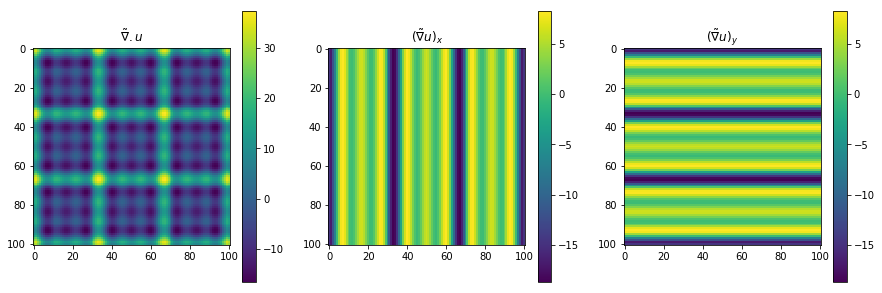

In [291]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

im0 = axs[0].imshow(np.real(normalized_div_recombined))
_ = fig.colorbar(im0, ax=axs[0])
axs[0].set_title(r"$\tilde{\nabla} . u$")

im1 = axs[1].imshow(np.real(normalized_gradx_recombined))
_ = fig.colorbar(im1, ax=axs[1])
axs[1].set_title(r"$(\tilde{\nabla} u)_x$")

im2 = axs[2].imshow(np.real(normalized_grady_recombined))
_ = fig.colorbar(im2, ax=axs[2])
axs[2].set_title(r"$(\tilde{\nabla} u)_y$")

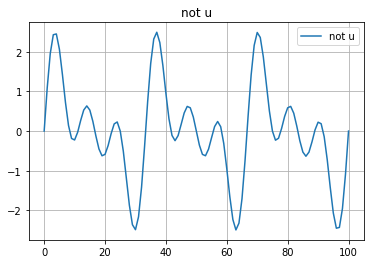

In [262]:
K = 3
def set_ic(u):
    for i in range(u.shape[0]):
        x = (i / (u.shape[0]-1))
        for k in range(1, K+1):
            u[i] += np.sin(2 * K * np.pi * k * x)
#         u[i] = x**3 - 2*x**2 + 4
#         u[i] = 1.5
    return u
size = 101
u = np.zeros((size,))
u = set_ic(u)
# u[:] = 1.5

# print(np.real(sfft.ifft(sfft.fft(u))))
temp = np.real(sfft.ifft(sfft.fft(u)))
temp -= 0.000000001 * temp
# temp[0] = 0.0
# print(temp)
plt.plot(temp, label='not u')
plt.legend()
plt.title('not u')
plt.grid()

[ 0.          0.00990099  0.01980198  0.02970297  0.03960396  0.04950495
  0.05940594  0.06930693  0.07920792  0.08910891  0.0990099   0.10891089
  0.11881188  0.12871287  0.13861386  0.14851485  0.15841584  0.16831683
  0.17821782  0.18811881  0.1980198   0.20792079  0.21782178  0.22772277
  0.23762376  0.24752475  0.25742574  0.26732673  0.27722772  0.28712871
  0.2970297   0.30693069  0.31683168  0.32673267  0.33663366  0.34653465
  0.35643564  0.36633663  0.37623762  0.38613861  0.3960396   0.40594059
  0.41584158  0.42574257  0.43564356  0.44554455  0.45544554  0.46534653
  0.47524752  0.48514851  0.4950495  -0.4950495  -0.48514851 -0.47524752
 -0.46534653 -0.45544554 -0.44554455 -0.43564356 -0.42574257 -0.41584158
 -0.40594059 -0.3960396  -0.38613861 -0.37623762 -0.36633663 -0.35643564
 -0.34653465 -0.33663366 -0.32673267 -0.31683168 -0.30693069 -0.2970297
 -0.28712871 -0.27722772 -0.26732673 -0.25742574 -0.24752475 -0.23762376
 -0.22772277 -0.21782178 -0.20792079 -0.1980198  -0.

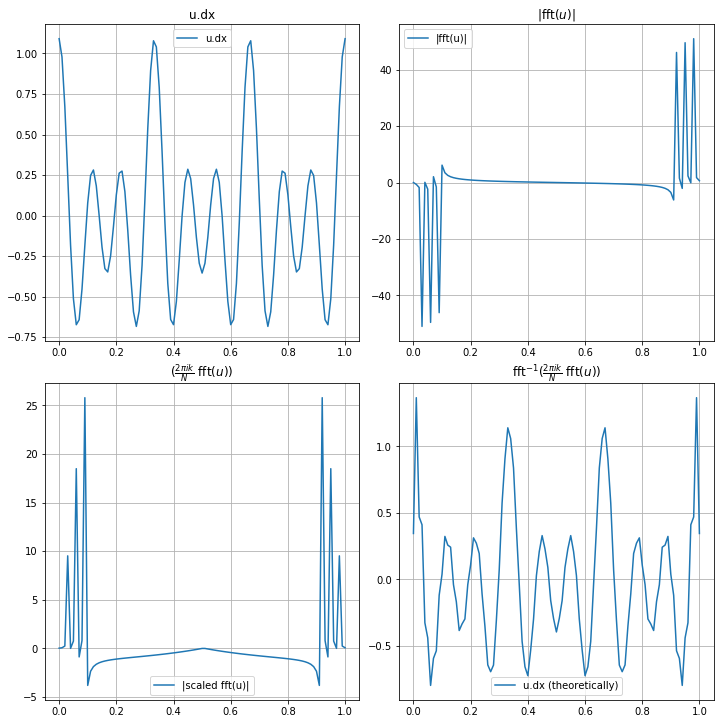

In [263]:
u_dx = np.zeros(u.shape, dtype=complex)
dx = 1
for i in range(u.shape[0]):
    if i == 0:
        u_dx[i] = (u[i+1] - u[i]) / dx
    elif i == u.shape[0]-1:
        u_dx[i] = (u[i] - u[i-1]) / dx
    else:
        u_dx[i] = (u[i+1] - u[i-1]) / (2 * dx)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs_i, axs_j = 0, 1
u_fft = sfft.fft(u)
_ = (axs[axs_i, axs_j].plot(np.linspace(0, 1, num=u.shape[0]), np.imag(u_fft), label='|fft(u)|'))
axs[axs_i, axs_j].set_title(r"|fft($u$)|")
axs[axs_i, axs_j].legend()
axs[axs_i, axs_j].grid()
# plots.append(row)
# print(u_fft)
# row2 = []

axs_i, axs_j = 0, 0
_ = (axs[axs_i, axs_j].plot(np.linspace(0, 1, num=u.shape[0]), u_dx, label='u.dx'))
axs[axs_i, axs_j].set_title(r"u.dx")
axs[axs_i, axs_j].legend()
axs[axs_i, axs_j].grid()

# Do scaling
axs_i, axs_j = 1, 0
scaled_ufft = np.array(u_fft)
N = u_fft.shape[0]
f = sfft.fftfreq(u.shape[0])
print(f)
for k in range(scaled_ufft.shape[0]):
    scaled_ufft[k] = (2j * np.pi * f[k]) * u_fft[k]
#     scaled_ufft[k] = u_fft[k]

_ = axs[axs_i, axs_j].plot(np.linspace(0, 1, num=u.shape[0]), np.real(scaled_ufft), label='|scaled fft(u)|')
axs[axs_i, axs_j].set_title(r"$(\frac{2\pi i k}{N}$ fft($u))$")
axs[axs_i, axs_j].legend()
axs[axs_i, axs_j].grid()

axs_i, axs_j = 1, 1
u_dx_recombined = sfft.ifft(scaled_ufft)

# print(u_dx_recombined / 10)
_ = axs[axs_i, axs_j].plot(np.linspace(0, 1, num=u.shape[0]), u_dx_recombined, label='u.dx (theoretically)')
axs[axs_i, axs_j].set_title(r"fft$^{-1}(\frac{2\pi i k}{N}$ fft($u))$")
axs[axs_i, axs_j].legend()
axs[axs_i, axs_j].grid()

fig.tight_layout(pad=0.5)
# plots.append(row2)

In [117]:
print(u_dx_recombined)
print(scaled_ufft)

[ 1.84601789e-15+27.34658809j  3.93745966e+00+28.16706272j
  7.81282323e+00+27.91507169j  1.15649739e+01+27.01236166j
  1.51347380e+01+25.57760596j  1.84658183e+01+23.67519947j
  2.15056816e+01+21.35602075j  2.42063874e+01+18.66856603j
  2.65253441e+01+15.66266051j  2.84259802e+01+12.39066182j
  2.98783216e+01 +8.9076289j   3.08594641e+01 +5.270996j
  3.13539344e+01 +1.53998323j  3.13539344e+01 -2.22514288j
  3.08594641e+01 -5.96389494j  2.98783216e+01 -9.61643551j
  2.84259802e+01-13.12446378j  2.65253441e+01-16.43209499j
  2.42063874e+01-19.48671305j  2.15056816e+01-22.23977946j
  1.84658183e+01-24.64758336j  1.51347380e+01-26.67191942j
  1.15649739e+01-28.28068194j  7.81282323e+00-29.44836495j
  3.93745966e+00-30.15645999j  2.22915368e-15-30.39374509j
 -3.93745966e+00-30.15645999j -7.81282323e+00-29.44836495j
 -1.15649739e+01-28.28068194j -1.51347380e+01-26.67191942j
 -1.84658183e+01-24.64758336j -2.15056816e+01-22.23977946j
 -2.42063874e+01-19.48671305j -2.65253441e+01-16.43209499j